In [2]:
###################################################################################################
###                             Motif Enrichment                                ###
###################################################################################################

#load libraries
library(tidyverse)
library(devtools)
library(motifmatchr)
library(BiocParallel)
load_all('/home/jpm73279/genome_downloads/BS_genomes/BSgenome.Zm_B73')
library(Matrix)
library(GenomicAlignments)
library(dplyr)
library(universalmotif)  # manipulating motif representations
library(TFBS)



── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2          ✔ readr     2.1.4     
✔ forcats   1.0.0.9000     ✔ stringr   1.5.1     
✔ ggplot2   3.4.4          ✔ tibble    3.2.1     
✔ lubridate 1.9.2          ✔ tidyr     1.3.0     
✔ purrr     1.0.2          
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“package ‘devtools’ was built under R version 4.3.1”
Loading required package: usethis



ℹ Loading BSgenome.Zm_B73
Loading required package: BSgenome

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, unio

ERROR: Error in library(TFBS): there is no package called ‘TFBS’


In [7]:
### Load Motifs for Analysis
core_motifs <- read_meme("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/00.data/conserved_consensus_motifs_Fig2B.meme")
de_novo_motifs <- read_meme("/home/jpm73279/genome_downloads/C4_markers/found_motifs/combined_unique_motifs.meme")
ms_de_novo_motifs <- read_meme("/home/jpm73279/genome_downloads/C4_markers/found_motifs/Ms.specific_CGTCGT_motif.comparative.meme")

all_assy_motifs <- c(core_motifs, de_novo_motifs, ms_de_novo_motifs)




all_assy_motifs_converted <- convert_motifs(all_assy_motifs, class = "TFBSTools-PWMatrix")

update_name <- function(pwm) {
    if (!is.null(pwm@name)) {
        pwm@ID <- pwm@name
    }
    return(pwm)
}

library(TFBSTools)
pw_matrix_list_converted <- lapply(all_assy_motifs_converted, update_name)
pw_matrix_list_converted <- lapply(pw_matrix_list_converted, PWMatrixList)
pw_matrix_list_converted <- do.call(c, pw_matrix_list_converted)


Attaching package: ‘TFBSTools’


The following object is masked from ‘package:Matrix’:

    Matrix




In [8]:
marker_file_paths <- c("/home/jpm73279/genome_downloads/C4_markers/Zm.c4_markers.bed")

# Function to read and process the file
process_file <- function(file_path) {
  species <- substr(basename(file_path), 1, 2)
  read_delim(file_path, delim = "\t", col_names = c("chrom", "start", "end", "geneID", "name", "type")) %>% 
    dplyr::select("chrom","start","end","geneID","name","type") %>%
    dplyr::mutate(species = (species))
}

# Apply the function to each file and store results in a list
list_of_dataframes <- lapply(marker_file_paths, process_file)

# Optionally combine all dataframes into one if needed
markers <- bind_rows(list_of_dataframes) %>% 
    dplyr::select(geneID,name,type,species)

Rows: 33 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom, geneID, name, type
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
###### Define a function to read the data and add columns
read_and_annotate_intersect <- function(file_path, species_abbr) {
  read_delim(file_path, delim = "\t", col_names = FALSE, col_types = "cccccccccc") %>%
    dplyr::mutate(
      species = species_abbr
    )
}

files_conditions <- list(
list(path = "/scratch/jpm73279/comparative_single_cell/07.call.ACRs/10.C4_gene_relationship_only_single_gene/all_acr_intersections/zm.extended_c4_genes.acr_intersection.all.bed", species = "Zm")
)

# Read and annotate each file and store results in a list
annotated_data_list <- lapply(files_conditions, function(condition) {
  read_and_annotate_intersect(condition$path, condition$species)
})

# Combine results
combined_acrs_species <- bind_rows(annotated_data_list)

all_acrs_species_types <- combined_acrs_species %>% 
    ungroup() %>% 
    dplyr::left_join(., markers, by = c("species", "X5" = "name")) %>% 
    dplyr::rename(name = X5) %>% 
    dplyr::rename(enzyme_location = type,
          locus = name,
          acr_name_type = X9) %>% 
    separate(acr_name_type, into = c("acr", "acr_cell_type_specific_class"), sep = ";") %>%
    dplyr::mutate(acr_cell_type_specific_class = case_when(acr_cell_type_specific_class == "bundle_sheath,procambial_meristem" ~ "bundle_sheath",
                                                          acr_cell_type_specific_class == "bundle_sheath,procambium" ~ "bundle_sheath", 
                                                          TRUE ~ acr_cell_type_specific_class)) %>% 
    tidyr::separate(locus, into = c("species_other", "loci"), sep = "__",remove = FALSE) %>%
    tidyr::separate(loci, into = c("gene_family", "number"), sep = "_", remove = FALSE)


##Only caring about DITs in this lifetime
filterd_DITs <- all_acrs_species_types %>% 
    dplyr::filter(gene_family == "DIT")

filterd_DITs_zm <- filterd_DITs  %>% 
    dplyr::filter(species == "Zm")

In [10]:
filterd_DITs_zm

X1,X2,X3,X4,locus,species_other,loci,gene_family,number,X6,X7,X8,acr,acr_cell_type_specific_class,X10,species,geneID,enzyme_location
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
chr1,185722816,185961183,Zm00001eb033390,Zm__DIT_2,Zm,DIT_2,DIT,2,chr1,185836927,185837428,scACR_4669,broadly_accessible,NA,Zm,Zm00001eb033390,bundle_sheath
chr1,185722816,185961183,Zm00001eb033390,Zm__DIT_2,Zm,DIT_2,DIT,2,chr1,185938709,185939210,scACR_4670,bundle_sheath,0.0166827933669214,Zm,Zm00001eb033390,bundle_sheath
chr1,185722816,185961183,Zm00001eb033390,Zm__DIT_2,Zm,DIT_2,DIT,2,chr1,185942210,185942711,scACR_4671,broadly_accessible,NA,Zm,Zm00001eb033390,bundle_sheath
chr1,185722816,185961183,Zm00001eb033390,Zm__DIT_2,Zm,DIT_2,DIT,2,chr1,185953019,185953520,scACR_4672,broadly_accessible,NA,Zm,Zm00001eb033390,bundle_sheath
chr1,185722816,185961183,Zm00001eb033390,Zm__DIT_2,Zm,DIT_2,DIT,2,chr1,185955816,185956317,scACR_4673,bundle_sheath,"6.66644445185161e-05,0.0104329855671478",Zm,Zm00001eb033390,bundle_sheath
chr2,193117739,193261359,Zm00001eb101270,Zm__DIT_1,Zm,DIT_1,DIT,1,chr2,193122438,193122939,scACR_17227,broadly_accessible,NA,Zm,Zm00001eb101270,mesophyll
chr2,193117739,193261359,Zm00001eb101270,Zm__DIT_1,Zm,DIT_1,DIT,1,chr2,193249567,193250068,scACR_17228,broadly_accessible,NA,Zm,Zm00001eb101270,mesophyll
chr2,193117739,193261359,Zm00001eb101270,Zm__DIT_1,Zm,DIT_1,DIT,1,chr2,193255463,193255964,scACR_17229,epidermis,0.0260324655844805,Zm,Zm00001eb101270,mesophyll
chr2,193117739,193261359,Zm00001eb101270,Zm__DIT_1,Zm,DIT_1,DIT,1,chr2,193256292,193256793,scACR_17230,mesophyll,0.00263324555848138,Zm,Zm00001eb101270,mesophyll


In [11]:
set.seed(420)

In [12]:
# `%ni%` <- Negate(`%in%`)# regions of interest: get peak region from last week's lecture
# header_bed <- c('chr','start','end','id','score')
# peaks <- read.table("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/03.peak_assignment/zm_dir/zm_acr_classification.no_exons.all_ACRs.classified.sorted.bed", 
#                     stringsAsFactors=FALSE, sep="\t") 

# colnames(peaks) <- header_bed
# broadly_acc_peaks <- peaks %>% 
#     separate(id, into = c("acr", "acr_cell_type_specific_class"), sep = ";") %>% 
#     dplyr::filter(acr_cell_type_specific_class == "broadly_accessible") %>% 
#     dplyr::filter(acr %ni% combined_acrs_marker_info$acr) %>% 
#     mutate(locus = "None",
#           gene_family = "None",
#           type = "None")


# all_peaks_final <- bind_rows(combined_acrs_marker_info, broadly_acc_peaks)



In [13]:
DIT_ACRs <- filterd_DITs_zm %>% 
    dplyr::select(X6, X7, X8, acr) %>%
    dplyr::rename(chr = "X6",
          start = "X7",
          end = "X8",
          id = "acr")
    

In [14]:
peaks_gr <- GRanges(DIT_ACRs, seqinfo=seqinfo(BSgenome.Zm_B73))
names(peaks_gr) <- as.character(peaks_gr)
peaks_gr <- unique(peaks_gr)

In [15]:
# get peak sequences, we'll need this later
peak_seqs <- getSeq(BSgenome.Zm_B73, peaks_gr) # <2s


# exclude peaks with any N's, to avoid warnings further down
hasNs    <- (alphabetFrequency(peak_seqs)[,"N"]>0)
addmargins(table(hasNs)) # => only drops 5 sequences

peak_seqs <- peak_seqs[!hasNs]
peaks_gr  <- peaks_gr[!hasNs]


# clean up
rm(peaks ,hasNs)

hasNs
FALSE   Sum 
   10    10 

Warning message in rm(peaks, hasNs):
“object 'peaks' not found”


In [43]:
# run: 30k sequences, 100 motifs
system.time(
  matches_rse <- matchMotifs(
    pw_matrix_list_converted, 
    peaks_gr, 
      genome = BSgenome.Zm_B73, 
    p.cutoff = .0005, # using a stringent p-value
    out="matches"
))  # <10s on my laptop

   user  system elapsed 
  0.150   0.001   0.152 

In [44]:
rse <- matches_rse

In [45]:
# run: 30k sequences, 100 motifs
system.time(
  matches_grl <- matchMotifs(
    pw_matrix_list_converted, 
    peaks_gr, 
      genome = BSgenome.Zm_B73, 
    p.cutoff = .0005, # using a stringent p-value
    out="positions"
))  # <10s on my laptop

   user  system elapsed 
  0.431   0.001   0.434 

In [46]:
hits <- findOverlaps(query = matches_grl, 
                     subject = peaks_gr, 
                     ignore.strand = TRUE)

In [47]:
mcols(matches_grl[queryHits(hits)])$feature <- "gene"

In [48]:
extractIDDataFrame <- function(pwMatrixList) {
  ids <- sapply(pwMatrixList@listData, function(item) item@ID)
  ids <- gsub("chr", "", ids, fixed = TRUE)
  indices <- seq_along(ids)
  
  data.frame(group = indices, TF_ID = ids)
}

# Example usage:
# Assuming your PWMatrixList object is named pwMatrixListObject
motif_id_index <- extractIDDataFrame(pw_matrix_list_converted)

In [49]:

tf_names <- motif_id_index$TF_ID
motif_intersection_list <- list(matches_grl)
for (i in seq_along(motif_intersection_list)) {
  # Add a new metadata column with the TF name corresponding to the index
  mcols(motif_intersection_list[[i]])$name <- tf_names[i]
}

In [50]:
granges_list <- motif_intersection_list
annotating_granges <- peaks_gr

In [51]:
# test <- granges_list[[1]][[1]] 
# overlaps <- findOverlaps(test , annotating_granges)
# ids <- annotating_granges$id[subjectHits(overlaps)]
# test$id<- ids[queryHits(overlaps)]

In [52]:
tf_mapping <- tf_names


In [53]:
# granges_list <- motif_intersection_list[[1]]
# # Annotate each GRanges object in the list with the corresponding TF ID
# for (i in seq_along(granges_list)) {
#     granges_list[[i]]$TF_ID <- tf_mapping[i]
    
#     overlaps <- findOverlaps(granges_list[[i]] , annotating_granges)
#     ids <- annotating_granges$id[subjectHits(overlaps)]
#     granges_list[[i]]$id <- ids[queryHits(overlaps)]
# }


In [54]:
granges_list <- motif_intersection_list[[1]]
# Annotate each GRanges object in the list with the corresponding TF ID
for (i in seq_along(granges_list)) {
    if (length(granges_list[[i]]) > 0) { # Check if the GRanges object is non-empty
        granges_list[[i]]$TF_ID <- tf_mapping[i]
        
        overlaps <- findOverlaps(granges_list[[i]], annotating_granges)
        
        # Check if there are any overlaps
        if (length(overlaps) > 0) {
            ids <- annotating_granges$id[subjectHits(overlaps)]
            granges_list[[i]]$id <- ids[queryHits(overlaps)]
        }
    }
}

In [55]:
final_data_frame <- as.data.frame(granges_list) %>% 
    dplyr::left_join(., filterd_DITs_zm, by = c("id" = "acr"))

In [56]:
unique(final_data_frame$locus)

[1] "Zm__DIT_2" "Zm__DIT_1"

In [294]:
tf_mapping

[1] "ARF"          "AS2LOB"       "BBRBPC"       "BES1"         "bHLH_TCP"    
 [6] "C2C2_Dof"     "C2C2_GATA"    "CAMTA"        "CPP"          "E2FDP"       
[11] "GARP_ARR-B"   "GARP_G2-like" "HD"           "HD_PLINC"     "HD-Zip_I_II" 
[16] "HD-Zip_IV"    "HSF"          "MADS_MIKC"    "NAC"          "SBP"         
[21] "WRKY"         "bs_DOF"       "bs_CATG"      "bs_GCCGCC"    "ms_GACGA"    
[26] "ms_AGCTA"     "ms_GACA"      "ms_CGTCGTCGT"

In [79]:
process_file <- function(file_info) {
  file_path <- file_info$path
  species <- file_info$species

  # Read and process the file
  read_delim(file_path, 
             col_names = c("qChr", "qStart", "qEnd", "acr_name", "pval", "refFile", "rChr", "rStart", "rEnd", "rName", "rWidth", "strand"),
             col_types = "cccccccccccc") %>%
    dplyr::mutate(species = species) %>%
    tidyr::separate(acr_name, into = c("acr", "acr_cell_type_specific_class", "locus"), sep = ";") %>%
    dplyr::mutate(
      refFile = str_replace(refFile, "\\.all_combined_regions\\.passing_regions\\.blast_passing_regions\\.intersecting_regions\\.ref\\.frac\\.bed", ""),
      refFile = str_replace(refFile, ".*\\.vs\\.", "")
    )
}

# Define file information as a list of lists
file_infos <- list(list(path = "/home/jpm73279/genome_downloads/C4_markers/conservation/Zm.all.ACR_conservation.intersection.bed", species = "Zm")
)

# Process each file
zm_sb_blast_acr_scored_conservation <- bind_rows(lapply(file_infos, process_file)) %>% 
  dplyr::filter(rName != ".") %>% 
  tidyr::separate(rName, into = c("RefFrom", "racr_name", "rcell_type", "gene_family", "gene_family2"), sep = ";", ) %>% 
    dplyr::select(acr, acr_cell_type_specific_class, locus, racr_name, rcell_type , gene_family, rWidth, species, rStart, rEnd) %>%
    separate(racr_name, into = c("rspecies", "racr"), sep = "_(.*)", extra = "merge", remove = FALSE) %>% 
    dplyr::mutate(acr_cell_type_specific_class = case_when(acr_cell_type_specific_class == "bundle_sheath,procambial_meristem" ~ "bundle_sheath",
                                                          acr_cell_type_specific_class == "bundle_sheath,procambium" ~ "bundle_sheath", 
                                                          TRUE ~ acr_cell_type_specific_class)) %>% 
    dplyr::mutate(qacr = str_c(species, acr, sep = "_")) %>% 
    dplyr::filter(rspecies == "Sb" & gene_family == "DIT")




In [120]:
zm_sb_blast_acr_scored_conservation %>% 
    dplyr::filter(acr == "scACR_17228")

acr,acr_cell_type_specific_class,locus,racr_name,rspecies,racr,rcell_type,gene_family,rWidth,species,rStart,rEnd,qacr
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




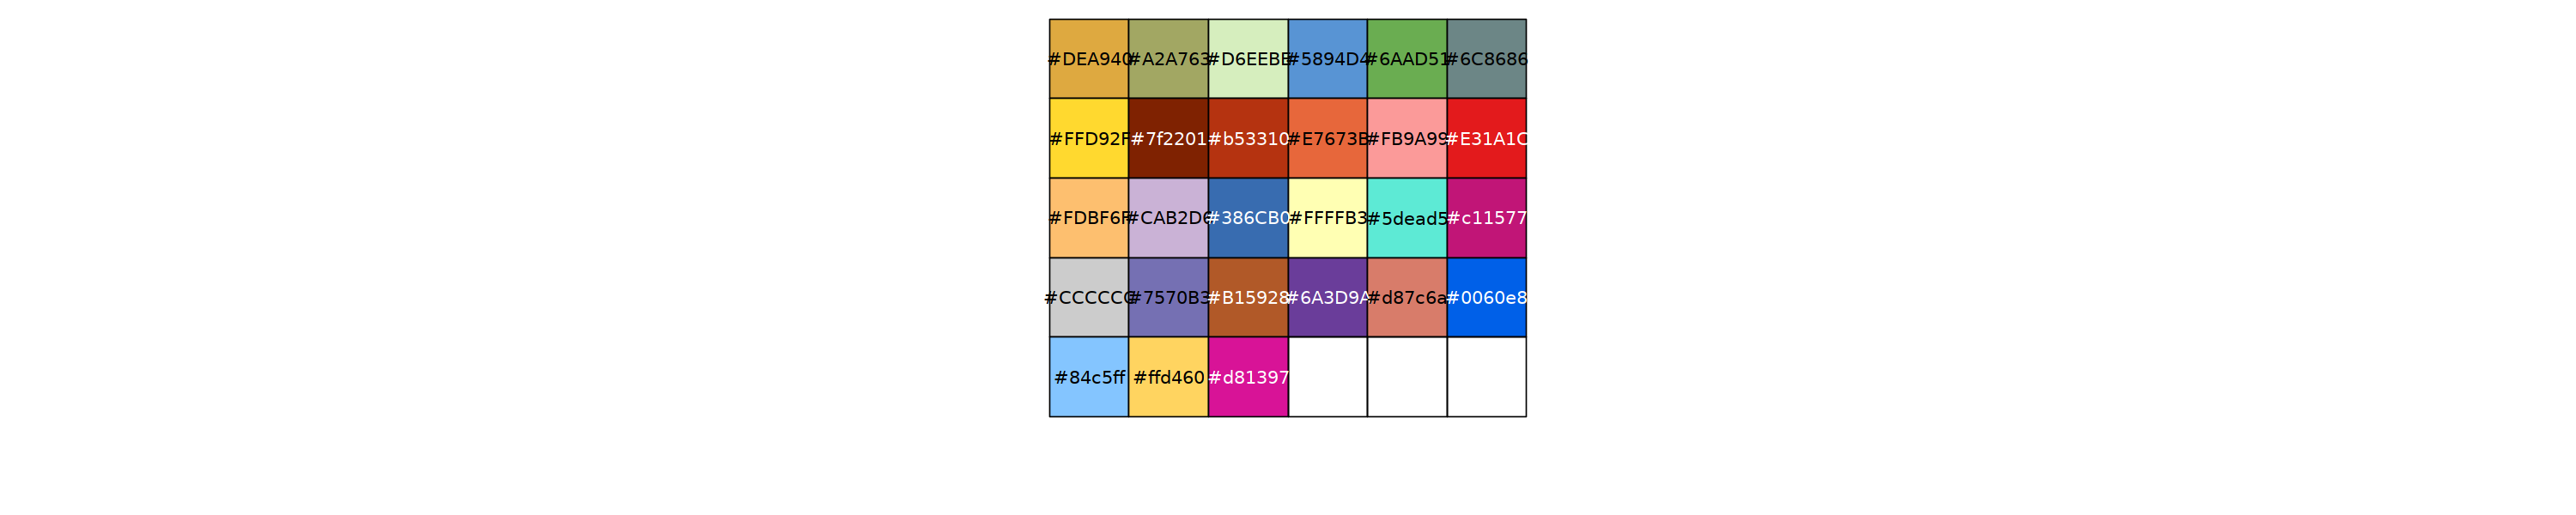

In [279]:
library(scales)
show_col(umap_cluster_colors)

In [295]:
# umap_cluster_colors <- c("#DEA940","#A2A763","#D6EEBE","#5894D4","#6AAD51","#6C8686","#FFD92F", "#7f2201","#b53310",
#                          "#E7673B","#FB9A99","#E31A1C","#FDBF6F","#CAB2D6","#386CB0","#FFFFB3", "#5dead5","#c11577",
#                          "#CCCCCC", "#7570B3","#B15928", "#6A3D9A", "#d87c6a", "#0060e8", "#84c5ff", "#ffd460", "#d81397")

# # Define colors for bs_ and ms_ prefixed strings
# bs_color <- "#34679A" # Somewhat blue color
# ms_color <- "#CB3533" # Somewhat red color

# # Function to assign color
# assign_color <- function(string) {
#   if (startsWith(string, "bs_")) {
#     return(bs_color)
#   } else if (startsWith(string, "ms_")) {
#     return(ms_color)
#   } else {
#     return(sample(umap_cluster_colors, 1)) # Randomly assign a color from the list for other strings
#   }
# }

# # List of characters to color
# characters <- c('AS2LOB','BBRBPC','BES1','bHLH_TCP','C2C2_Dof','CAMTA','E2FDP','GARP_ARR-B','GARP_G2-like','HD','HD_PLINC','HD-Zip_I_II','HD-Zip_IV','HSF','MADS_MIKC','NAC','WRKY','bs_DOF','bs_CATG','bs_GCCGCC','ms_GACGA','ms_AGCTA','ms_GACA','ms_CGTCGTCGT')

# colored_characters <- setNames(sapply(characters, assign_color), characters)
colored_characters <- c(
  ARF = '#8c564b',            # Brown
  AS2LOB = '#FFFFB3',         # Light Yellow
  BBRBPC = '#c11577',         # Deep Pink
  BES1 = '#6C8686',           # Slate Gray
  bHLH_TCP = '#A2A763',       # Olive Green
  C2C2_Dof = '#386CB0',       # Dark Blue
  C2C2_GATA = '#17becf',      # Cyan
  CAMTA = '#FFD92F',          # Yellow
  CPP = '#e377c2',            # Pink
  E2FDP = '#d87c6a',          # Soft Red
  "GARP_ARR-B" = '#D6EEBE',   # Light Green
  "GARP_G2-like" = '#5894D4', # Sky Blue
  HD = '#6AAD51',             # Green
  HD_PLINC = '#ffd460',       # Golden Yellow
  "HD-Zip_I_II" = '#CCCCCC',  # Light Gray
  "HD-Zip_IV" = '#DEA940',    # Orange
  HSF = '#7570B3',            # Lavender
  MADS_MIKC = '#84c5ff',      # Light Blue
  NAC = '#E7673B',            # Vermilion
  SBP = '#2ca02c',            # Dark Green
  WRKY = '#FB9A99',           # Soft Pink
  bs_DOF = '#34679A',         # Unchanged
  bs_CATG = '#34679A',        # Unchanged
  bs_GCCGCC = '#34679A',      # Unchanged
  ms_GACGA = '#CB3533',       # Unchanged
  ms_AGCTA = '#CB3533',       # Unchanged
  ms_GACA = '#CB3533',        # Unchanged
  ms_CGTCGTCGT = '#CB3533'    # Unchanged
)

In [296]:
colores_characters

AS2LOB       BBRBPC         BES1     bHLH_TCP     C2C2_Dof        CAMTA 
   "#FFFFB3"    "#c11577"    "#B15928"    "#A2A763"    "#386CB0"    "#FDBF6F" 
       E2FDP   GARP_ARR-B GARP_G2-like           HD     HD_PLINC  HD-Zip_I_II 
   "#d87c6a"    "#D6EEBE"    "#B15928"    "#6AAD51"    "#ffd460"    "#CCCCCC" 
   HD-Zip_IV          HSF    MADS_MIKC          NAC         WRKY       bs_DOF 
   "#DEA940"    "#386CB0"    "#84c5ff"    "#b53310"    "#d81397"    "#34679A" 
     bs_CATG    bs_GCCGCC     ms_GACGA     ms_AGCTA      ms_GACA ms_CGTCGTCGT 
   "#34679A"    "#34679A"    "#CB3533"    "#CB3533"    "#CB3533"    "#CB3533"

Warning message:
“ggrepel: 12 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 21 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 23 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 30 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 23 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 19 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 13 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


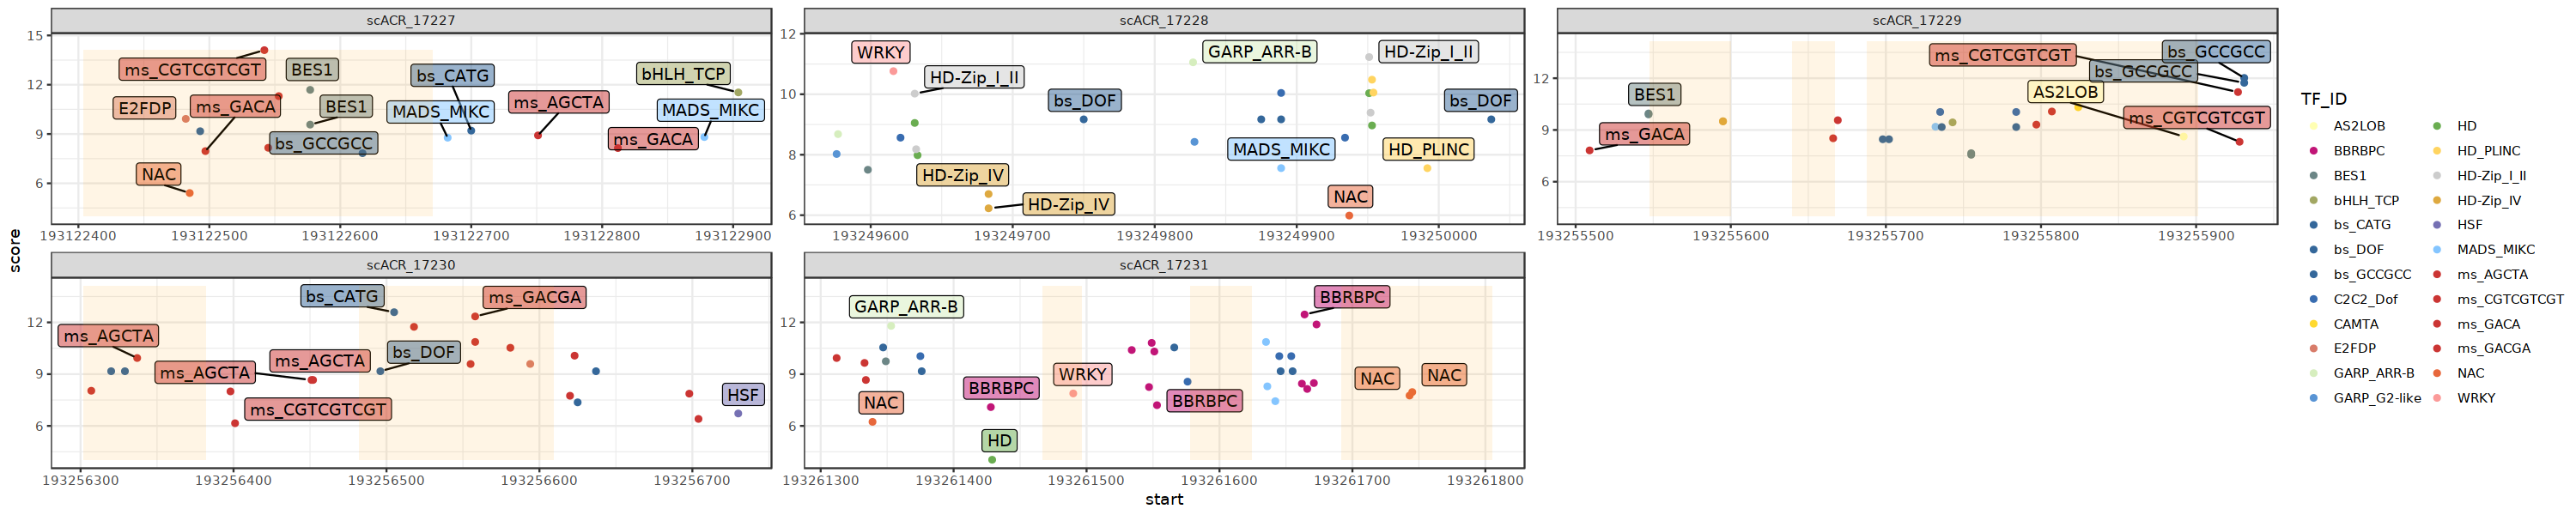

In [305]:
### plotting_dit_1
dit_1_acrs <- final_data_frame %>% 
    filter(locus == "Zm__DIT_1")  

dit_1_acrs$color <- colored_characters[dit_1_acrs$TF_ID]
dit_1_acrs$color[is.na(dit_1_acrs$color)] <- "grey"

highlight_data_dit_1 <- zm_sb_blast_acr_scored_conservation %>%
  tidyr::crossing(id = facet_levels) %>%
  dplyr::mutate(rStart = as.numeric(as.character(rStart)),
                rEnd = as.numeric(as.character(rEnd))) %>% 
    dplyr::filter(locus == "Zm__DIT_1") %>% 
    dplyr::filter(id %in% dit_1_acrs$id) %>% 
    dplyr::filter(acr == id)


zm_dit_1 <- ggplot(dit_1_acrs, aes(x = start, y = score, color = TF_ID)) +
    geom_point() +
    geom_label_repel(aes(label = TF_ID, color = "black", fill = TF_ID), 
                     nudge_x = 0.5, 
                     nudge_y = 0.5, 
                     max.overlaps = 5,
                     box.padding = 0.35, 
                     point.padding = 0.5,
                     hjust = 0.5, 
                     vjust = 0.5,
                     color = 'black', 
                     fill = alpha(dit_1_acrs$color, .5)) +
    scale_color_manual(values = colored_characters) +
    facet_wrap(~id, scales = "free") +
    theme_bw() +
    geom_rect(data = highlight_data_dit_1, inherit.aes = FALSE, 
              aes(xmin = rStart, xmax = rEnd, 
                  ymin = min(dit_1_acrs$score),
                  ymax = max(dit_1_acrs$score)), 
              color = "transparent", fill = "orange", alpha = 0.1) +
    guides(color = guide_legend(title = "TF_ID"))

zm_dit_1

ggsave(plot = zm_dit_1, 
       filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_7/motif_locations/Zm.dit1.motif_location.pdf",
      width = 26,
      height = 8)

Warning message:
“ggrepel: 13 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 15 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 25 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 12 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


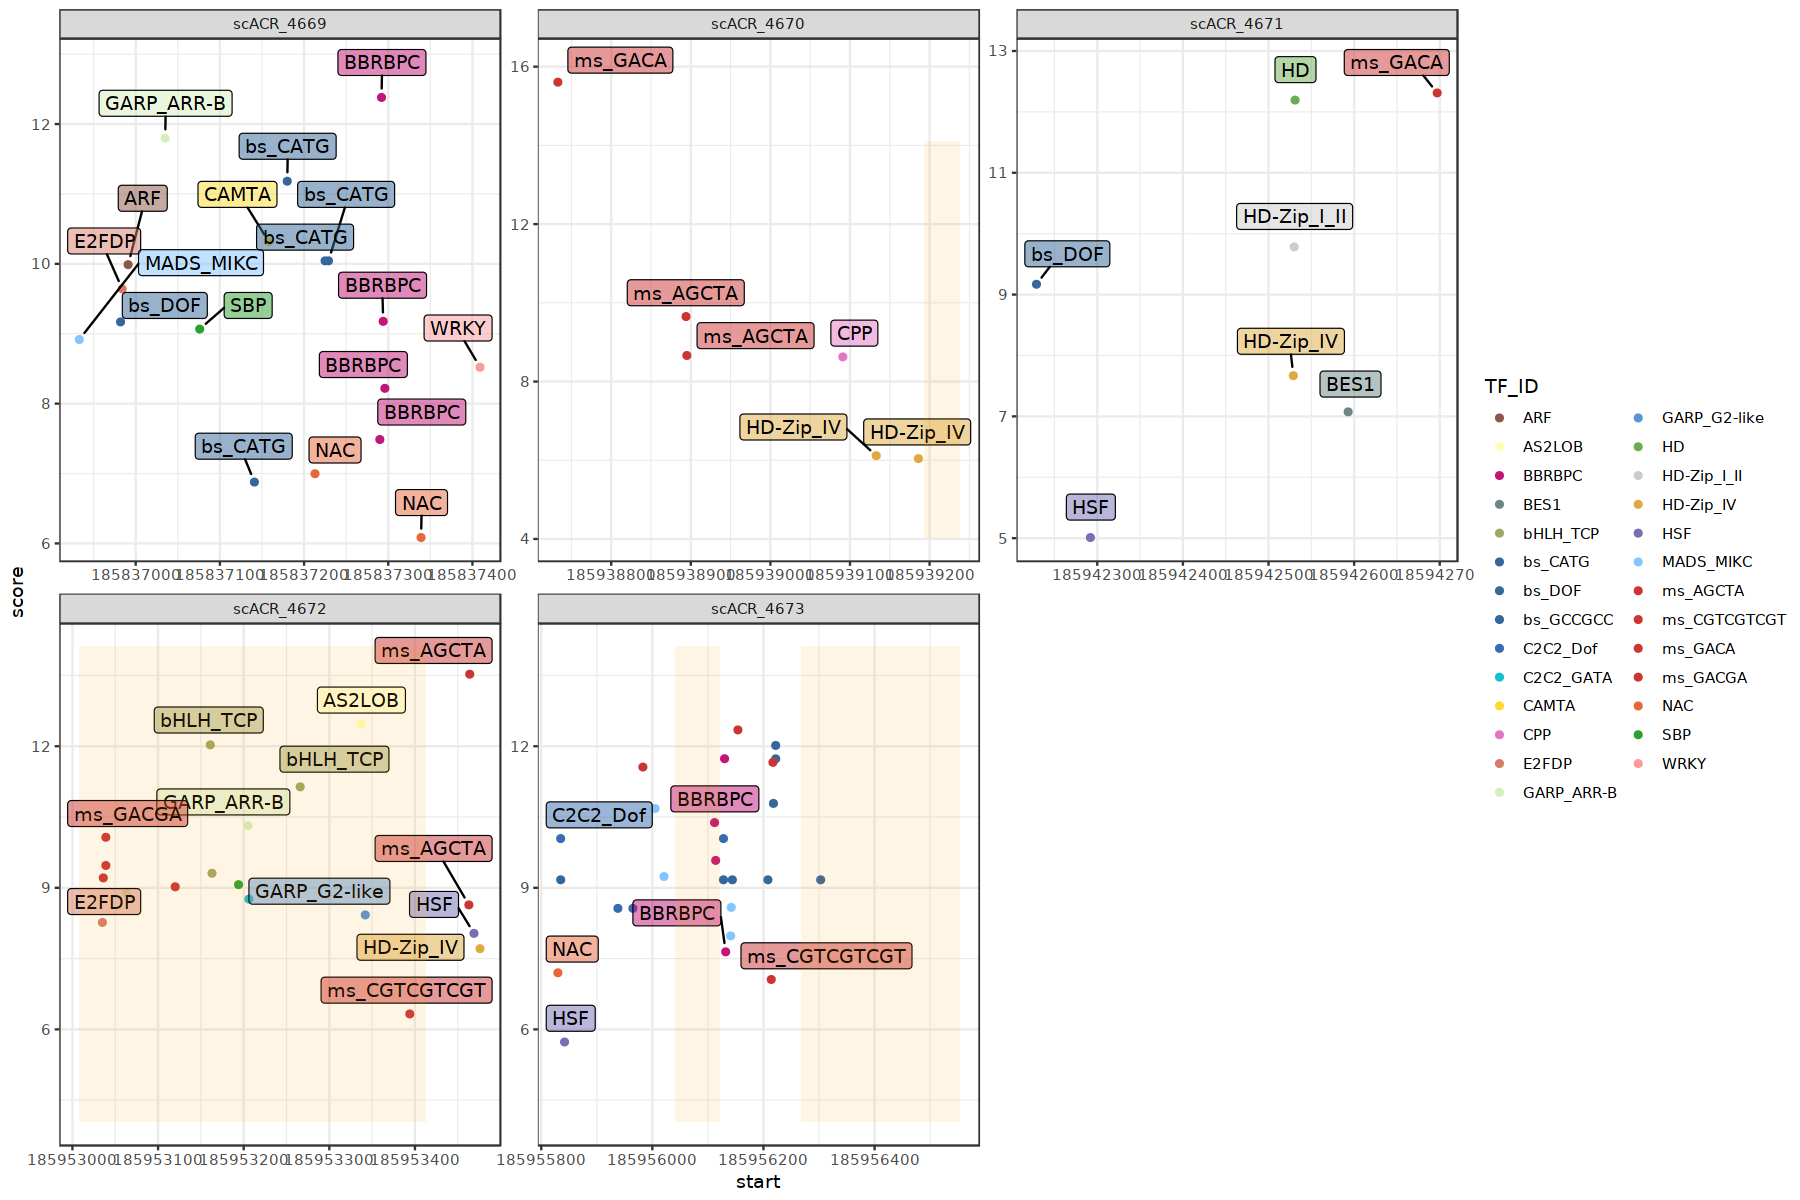

In [306]:

options(repr.plot.width=15, repr.plot.height=10)

### plotting_dit_2
dit_2_acrs <- final_data_frame %>% 
    filter(locus == "Zm__DIT_2")  


dit_2_acrs$color <- colored_characters[dit_2_acrs$TF_ID]
dit_2_acrs$color[is.na(dit_2_acrs$color)] <- "grey"

highlight_data_dit_2 <- zm_sb_blast_acr_scored_conservation %>%
  tidyr::crossing(id = facet_levels) %>%
  dplyr::mutate(rStart = as.numeric(as.character(rStart)),
                rEnd = as.numeric(as.character(rEnd))) %>% 
    dplyr::filter(locus == "Zm__DIT_2") %>% 
    dplyr::filter(id %in% dit_2_acrs$id) %>% 
    dplyr::filter(acr == id)

# zm_dit_2 <- ggplot(dit_2_acrs, aes(start, score, color = TF_ID)) + 
#     geom_point() + 
#     geom_label_repel(aes(label = TF_ID, size = 1, 
#                         max.overlaps = 5)) +
#     facet_wrap(~id, scales = "free") + 
#     theme_bw() +
#     geom_rect(data=highlight_data_dit_2, inherit.aes=FALSE, 
#               aes(xmin=rStart, xmax=rEnd, 
#                   ymin=min(dit_2_acrs$score),
#                 ymax=max(dit_2_acrs$score)), color="transparent", fill="orange", alpha=0.1)
# zm_dit_2


zm_dit_2 <- ggplot(dit_2_acrs, aes(x = start, y = score, color = TF_ID)) +
    geom_point() +
    geom_label_repel(aes(label = TF_ID, color = "black", fill = TF_ID), 
                     nudge_x = 0.5, 
                     nudge_y = 0.5, 
                     max.overlaps = 5,
                     box.padding = 0.35, 
                     point.padding = 0.5,
                     hjust = 0.5, 
                     vjust = 0.5,
                     color = 'black', 
                     fill = alpha(dit_2_acrs$color, .5)) +
    scale_color_manual(values = colored_characters) +
    facet_wrap(~id, scales = "free") +
    theme_bw() +
    geom_rect(data = highlight_data_dit_2, inherit.aes = FALSE, 
              aes(xmin = rStart, xmax = rEnd, 
                  ymin = min(dit_1_acrs$score),
                  ymax = max(dit_1_acrs$score)), 
              color = "transparent", fill = "orange", alpha = 0.1) +
    guides(color = guide_legend(title = "TF_ID"))


zm_dit_2

ggsave(plot = zm_dit_2, 
       filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_7/motif_locations/Zm.dit2.motif_location.pdf",
      width = 26,
      height = 8)

`summarise()` has grouped output by 'id'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'id'. You can override using the `.groups`
argument.


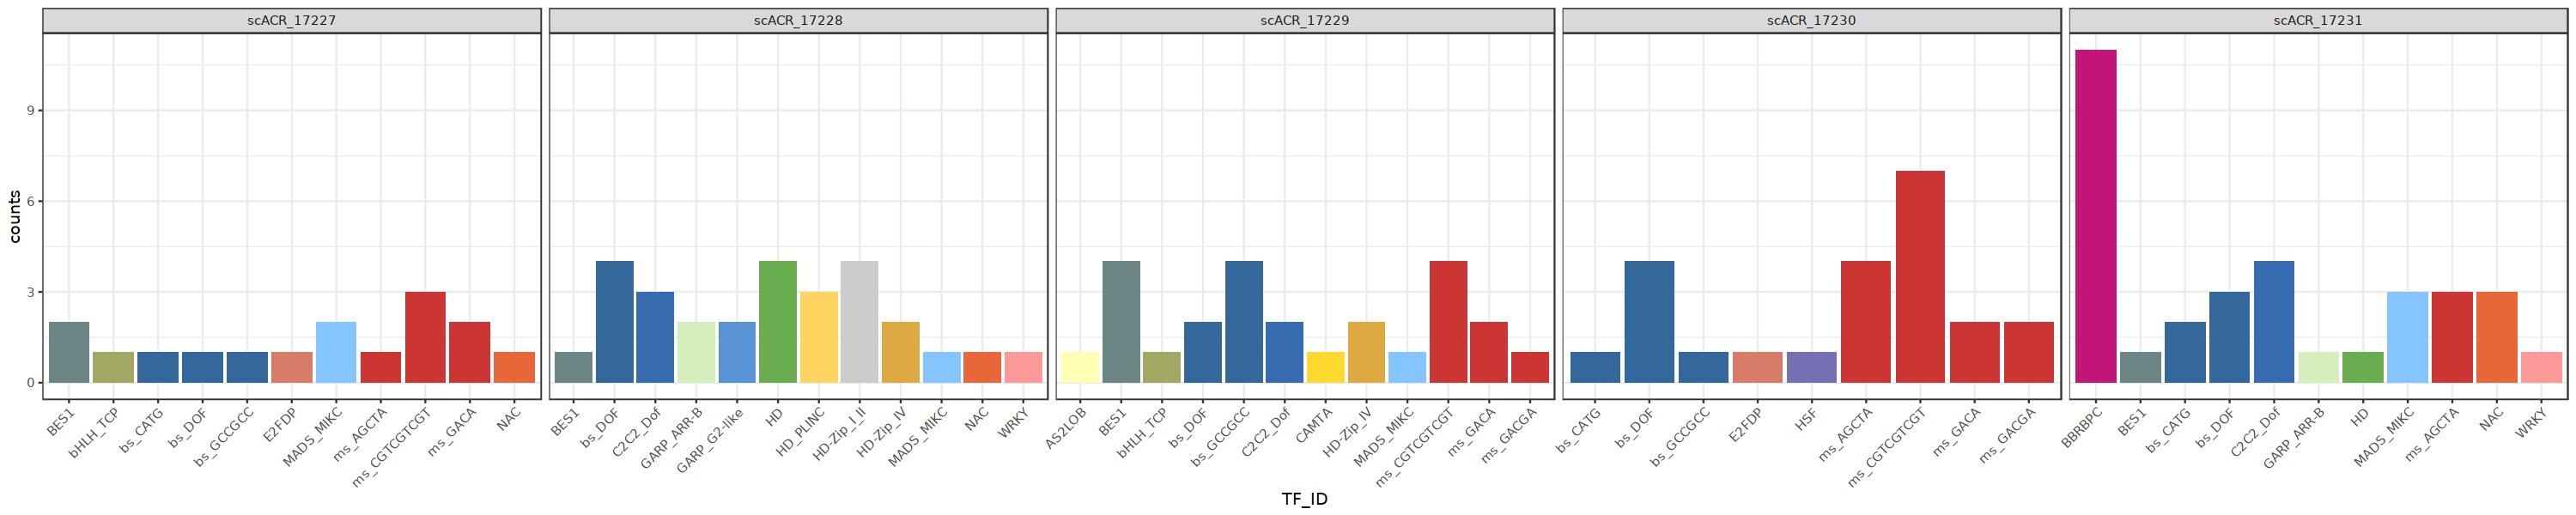

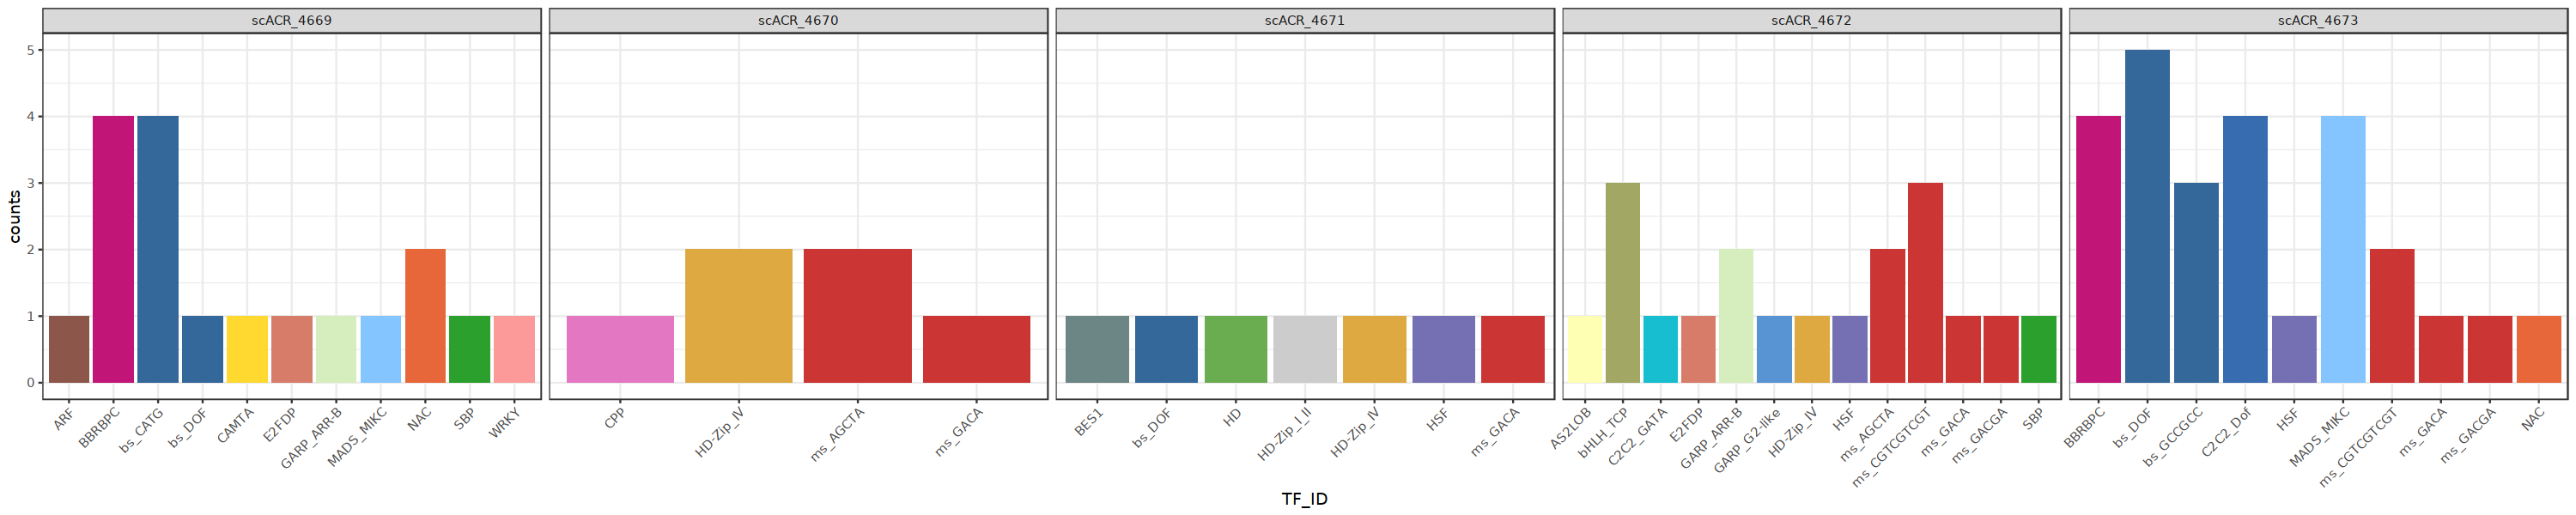

In [307]:
## Counting the Number of motifs PER ACR

dit_1_counts_motifs <- dit_1_acrs %>% 
    dplyr::group_by(id, TF_ID) %>% 
    dplyr::summarise(counts = n()) %>% 
    dplyr::ungroup()


dit_1_counts_motifs$color <- colored_characters[dit_1_counts_motifs$TF_ID]
dit_1_counts_motifs$color[is.na(dit_1_counts_motifs$color)] <- "grey"

options(repr.plot.width=25, repr.plot.height=5)

dit_1_motif_counts_acrs <- ggplot(dit_1_counts_motifs, aes(x = TF_ID, y = counts)) +
 geom_col(aes(fill = color)) + # Here we use 'fill' aesthetic mapped to 'color' column
  facet_grid(~ id, scales = "free") +
  scale_fill_identity() + # Use the actual colors specified in 'color' column
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) # Rotate x-axis text to 45 degrees

dit_1_motif_counts_acrs



## Counting the Number of motifs PER ACR
dit_2_counts_motifs <- dit_2_acrs %>% 
    dplyr::group_by(id, TF_ID) %>% 
    dplyr::summarise(counts = n()) %>% 
    dplyr::ungroup()


dit_2_counts_motifs$color <- colored_characters[dit_2_counts_motifs$TF_ID]
dit_2_counts_motifs$color[is.na(dit_2_counts_motifs$color)] <- "grey"

options(repr.plot.width=25, repr.plot.height=5)

dit_2_motif_counts_acrs <- ggplot(dit_2_counts_motifs, aes(x = TF_ID, y = counts)) +
 geom_col(aes(fill = color)) + # Here we use 'fill' aesthetic mapped to 'color' column
  facet_grid(~ id, scales = "free") +
  scale_fill_identity() + # Use the actual colors specified in 'color' column
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) # Rotate x-axis text to 45 degrees

dit_2_motif_counts_acrs



ggsave(plot = dit_1_motif_counts_acrs, 
       filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_7/motif_counts/Zm.dit1.motif_count.pdf",
      width = 40,
      height = 4)



ggsave(plot = dit_2_motif_counts_acrs, 
       filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_7/motif_counts/Zm.dit2.motif_count.pdf",
      width = 40,
      height = 4)

In [280]:
colored_characters

AS2LOB       BBRBPC         BES1     bHLH_TCP     C2C2_Dof        CAMTA 
   "#FFFFB3"    "#c11577"    "#B15928"    "#A2A763"    "#6C8686"    "#FDBF6F" 
       E2FDP   GARP_ARR-B GARP_G2-like           HD     HD_PLINC  HD-Zip_I_II 
   "#386CB0"    "#D6EEBE"    "#d87c6a"    "#0060e8"    "#FDBF6F"    "#CCCCCC" 
   HD-Zip_IV          HSF    MADS_MIKC          NAC         WRKY       bs_DOF 
   "#CAB2D6"    "#386CB0"    "#84c5ff"    "#b53310"    "#DEA940"    "#34679A" 
     bs_CATG    bs_GCCGCC     ms_GACGA     ms_AGCTA      ms_GACA ms_CGTCGTCGT 
   "#34679A"    "#34679A"    "#CB3533"    "#CB3533"    "#CB3533"    "#CB3533"

In [58]:
# # Assuming 'id' is the facet variable
# facet_levels <- unique(final_data_frame$id)

# # Replicate highlighting data for each facet
# highlight_data <- zm_sb_blast_acr_scored_conservation %>%
#   tidyr::crossing(id = facet_levels) %>%
#   dplyr::mutate(rStart = as.numeric(as.character(rStart)),
#                 rEnd = as.numeric(as.character(rEnd))) %>% 
#     filter(locus == "Zm__DIT_1") %>% 
#     dplyr::

# # Plotting
# options(repr.plot.width=15, repr.plot.height=15)
# final_data_frame %>% 
#     filter(locus == "Zm__DIT_1") %>% 
#     ggplot(aes(start, score)) + 
#     geom_point() + 
#     geom_label_repel(aes(label = TF_ID)) +
#     facet_wrap(~id, scales = "free") + 
#     theme_bw() +
#     annotate(data = highlight_data, 
#             aes(aes(xmin = rStart, xmax = rEnd, 
#                    ymin = final_data_frame$score, ymax = final_data_frame$score)),
#              color = "transparent", fill = "orange", alpha = 0.3)
#     # geom_rect(data = highlight_data, 
#     #           inherit.aes = FALSE, 
#     #           aes(xmin = rStart, xmax = rEnd, 
#     #               ymin = -Inf, ymax = Inf), 
#     #           color = "transparent", fill = "orange", alpha = 0.3)

# library(ggrepel)
# library(cowplot)

# options(repr.plot.width=15, repr.plot.height=15)
# final_data_frame %>% 
#     dplyr::filter(locus == "Zm__DIT_1") %>% 
#     ggplot(., aes(start, score)) + 
#     geom_point() + 
#     geom_label_repel(aes(label = TF_ID)) +
#     facet_wrap(id~., scales = "free") + 
#     theme_bw() 


# library(ggrepel)
# library(cowplot)


# options(repr.plot.width=15, repr.plot.height=15)
# final_data_frame %>% 
#     dplyr::filter(locus == "Zm__DIT_2") %>% 
#     ggplot(., aes(start, score)) + 
#     geom_point() + 
#     geom_label_repel(aes(label = TF_ID)) +
#     facet_wrap(id~., scales = "free") + theme_bw()

In [59]:
acr_count <- filterd_DITs %>% 
    dplyr::select(locus, acr) %>% 
    group_by(locus) %>% 
    summarise(n_acrs = n())

In [152]:
options(repr.plot.width=30, repr.plot.height=5)
zm_count_motifs_per_acr <- final_data_frame %>% 
    left_join(.,acr_count , by = "locus") %>% 
    dplyr::group_by(id, TF_ID, n_acrs) %>% 
    dplyr::summarise(total_motif_occurence = n(),
                    controlled_motif_occ  = total_motif_occurence/n_acrs) %>% 
    ggplot(., aes(x = locus, y = controlled_motif_occ)) + 
    geom_bar(stat="identity") + 
    facet_grid(ID ~ .) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + theme_bw()

zm_count_motifs_per_acr

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'locus', 'TF_ID', 'n_acrs'. You can
override using the `.groups` argument.
ERROR while rich displaying an object: Error in `combine_vars()`:
! At least one layer must contain all faceting variables: `ID`
✖ Plot is missing `ID`
✖ Layer 1 is missing `ID`

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr,